In [10]:
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# packages for plotting
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   ,
            'figure.dpi': 300
           })

#### Omission baseline

In [11]:
def get_split(all_x, all_y, N):  
  index = np.random.choice(len(all_x), size=N)
  mask = np.repeat(False, len(all_x))
  mask[index] = True
  return all_x[mask], all_y[mask]

In [12]:
def filterdata_by_label(data, threshold, omitregion):
    if omitregion not in ['above', 'below']:
        raise ValueError("omitregion must be either 'above' or 'below'")
    x,y = data
    filtered_x = []
    filtered_y = []
    
    for i, curr_y in enumerate(y):
        if omitregion == 'above':
            if curr_y < threshold:
                filtered_x.append(x[i])
                filtered_y.append(curr_y)
        else:
            if curr_y > threshold:
                filtered_x.append(x[i])
                filtered_y.append(curr_y)
    return np.array(filtered_x), np.array(filtered_y)

<ipython-input-13-37f376298219>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


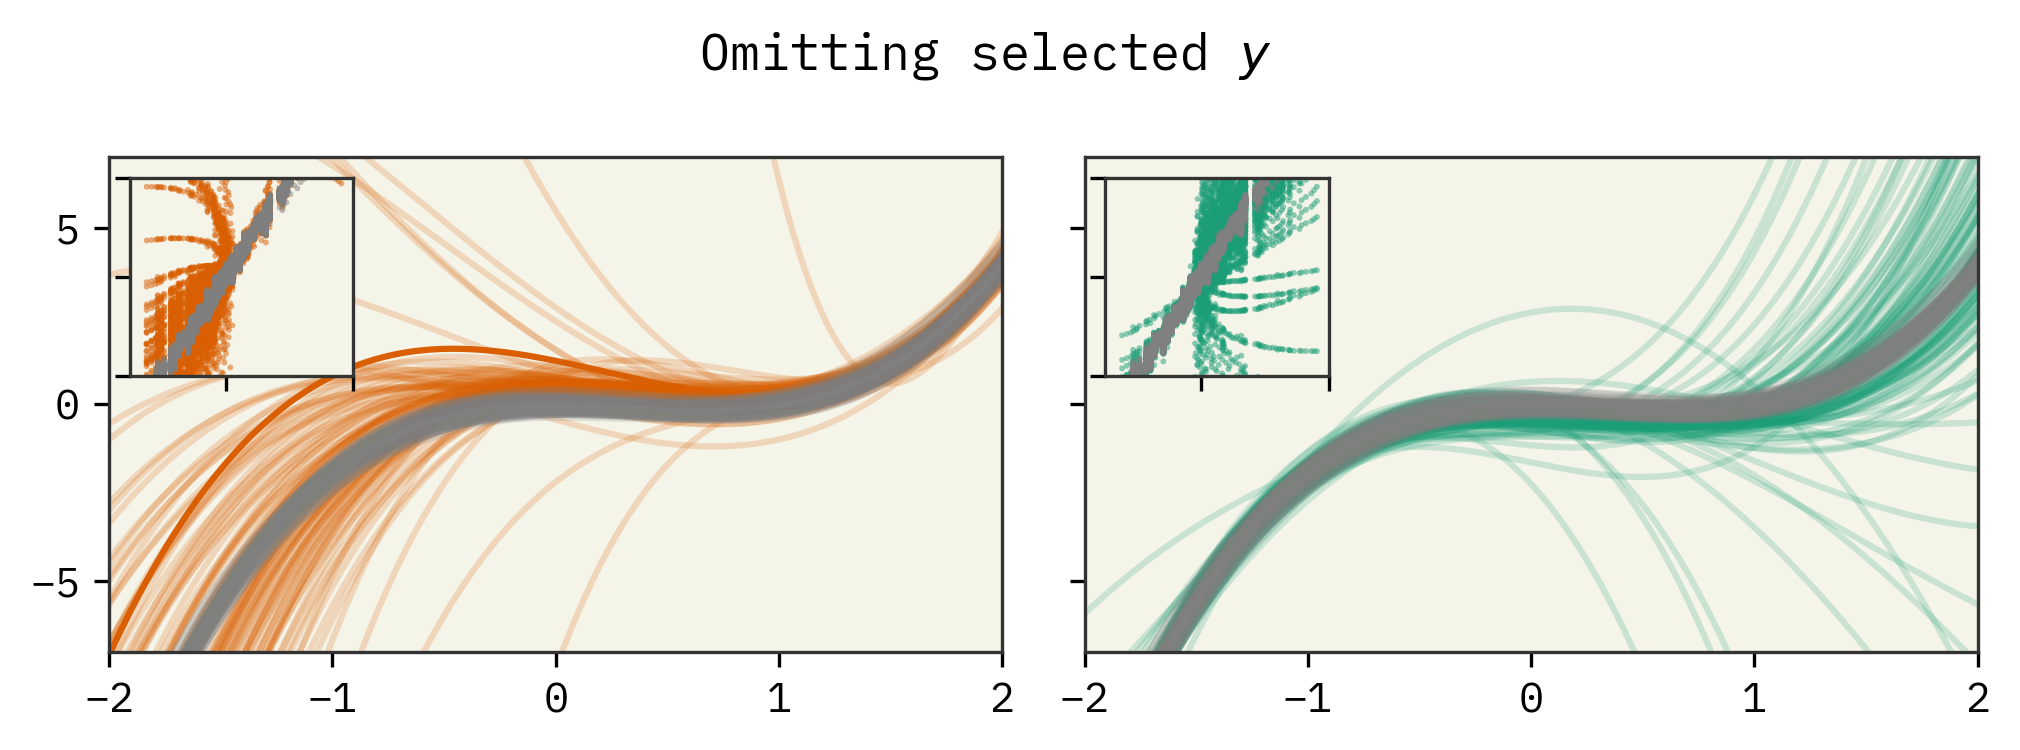

In [13]:
fig, (ax1,ax0) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(7,2.5))
fig.suptitle('Omitting selected $y$')
axins0 = inset_axes(ax0, width="25%", height="40%", loc=2)
axins1 = inset_axes(ax1, width="25%", height="40%", loc=2)


N = 101
M = 200
TRAIN_N = 25
all_x = np.linspace(-2,3, M)
all_y = all_x ** 3 - all_x**2 + 0.5 * np.random.normal(size=(M,))
all_xmat = np.stack((np.ones_like(all_x), all_x, all_x**2, all_x**3), axis=1)
yhats = np.zeros((4, N * M))
index = 0

avg = np.zeros_like(all_x)
for i in range(N):
    x0, y0 = get_split(all_x, all_y, TRAIN_N)
    x, y = filterdata_by_label((x0,y0), 0, omitregion='above')
    xmat = np.stack((np.ones_like(x), x, x**2, x**3), axis=1)
    beta = np.linalg.lstsq(xmat, y, rcond=None)
    yhats[index, i * M:(i+1) * M] = all_xmat @ beta[0]
    ax0.plot(all_x, all_xmat @ beta[0], 'C0', alpha=0.2)
    avg += all_xmat @ beta[0]
ax0.plot(all_x, avg / N, 'C0', label='y>0 noising')
index += 1

avg = np.zeros_like(all_x)
for i in range(N):
    x0, y0 = get_split(all_x, all_y, TRAIN_N)
    x, y = filterdata_by_label((x0,y0), 0, omitregion='below')
    xmat = np.stack((np.ones_like(x), x, x**2, x**3), axis=1)
    beta = np.linalg.lstsq(xmat, y, rcond=None)
    yhats[index, i * M:(i+1) * M] = all_xmat @ beta[0]
    ax1.plot(all_x, all_xmat @ beta[0], 'C1', alpha=0.2)
    avg += all_xmat @ beta[0]
ax1.plot(all_x, avg / N, 'C1', label='y<0 noising')
index += 1

avg = np.zeros_like(all_x)
for i in range(N):
    x, y = get_split(all_x, all_y, TRAIN_N)
    xmat =  np.stack((np.ones_like(x), x, x**2, x**3), axis=1)
    beta = np.linalg.lstsq(xmat, y, rcond=None)
    yhats[index, i * M:(i+1) * M] = all_xmat @ beta[0]
    ax0.plot(all_x, all_xmat @ beta[0], 'gray', alpha=0.2)
    ax1.plot(all_x, all_xmat @ beta[0], 'gray', alpha=0.2)
    avg += all_xmat @ beta[0]
ax0.plot(all_x, avg / N, 'gray', label='no noising')
ax1.plot(all_x, avg / N, 'gray', label='no noising')


ax0.set(xlim=(-2, 2), ylim=(-7, 7)) #, xlabel='x', ylabel='y')
ax1.set(xlim=(-2, 2), ylim=(-7, 7)) #, xlabel='x', ylabel='y')

all_y = np.tile(all_y, N)
axins0.scatter(all_y, yhats[0], s=2, color='C0', alpha=0.5, edgecolors='none', label='y > 0 omission')
axins0.scatter(all_y, yhats[2], s=2, color='gray', alpha=0.5,  edgecolors='none', label='no noising')
axins0.tick_params(labelleft=False, labelbottom=False)
axins0.set(xlim=(-15,20),ylim=(-10,10))
axins1.scatter(all_y, yhats[1], s=2, color='C1', alpha=0.5,edgecolors='none',  label='y < 0 omission')
axins1.scatter(all_y, yhats[2], s=2, color='gray', alpha=0.5,  edgecolors='none', label='no noising')
axins1.tick_params(labelleft=False, labelbottom=False)
axins1.set(xlim=(-15,20),ylim=(-10,10))

fig.tight_layout()
plt.savefig('polyreg_omission.png',dpi=300)


#### Y noise

<ipython-input-14-a3eb6ecafac2>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


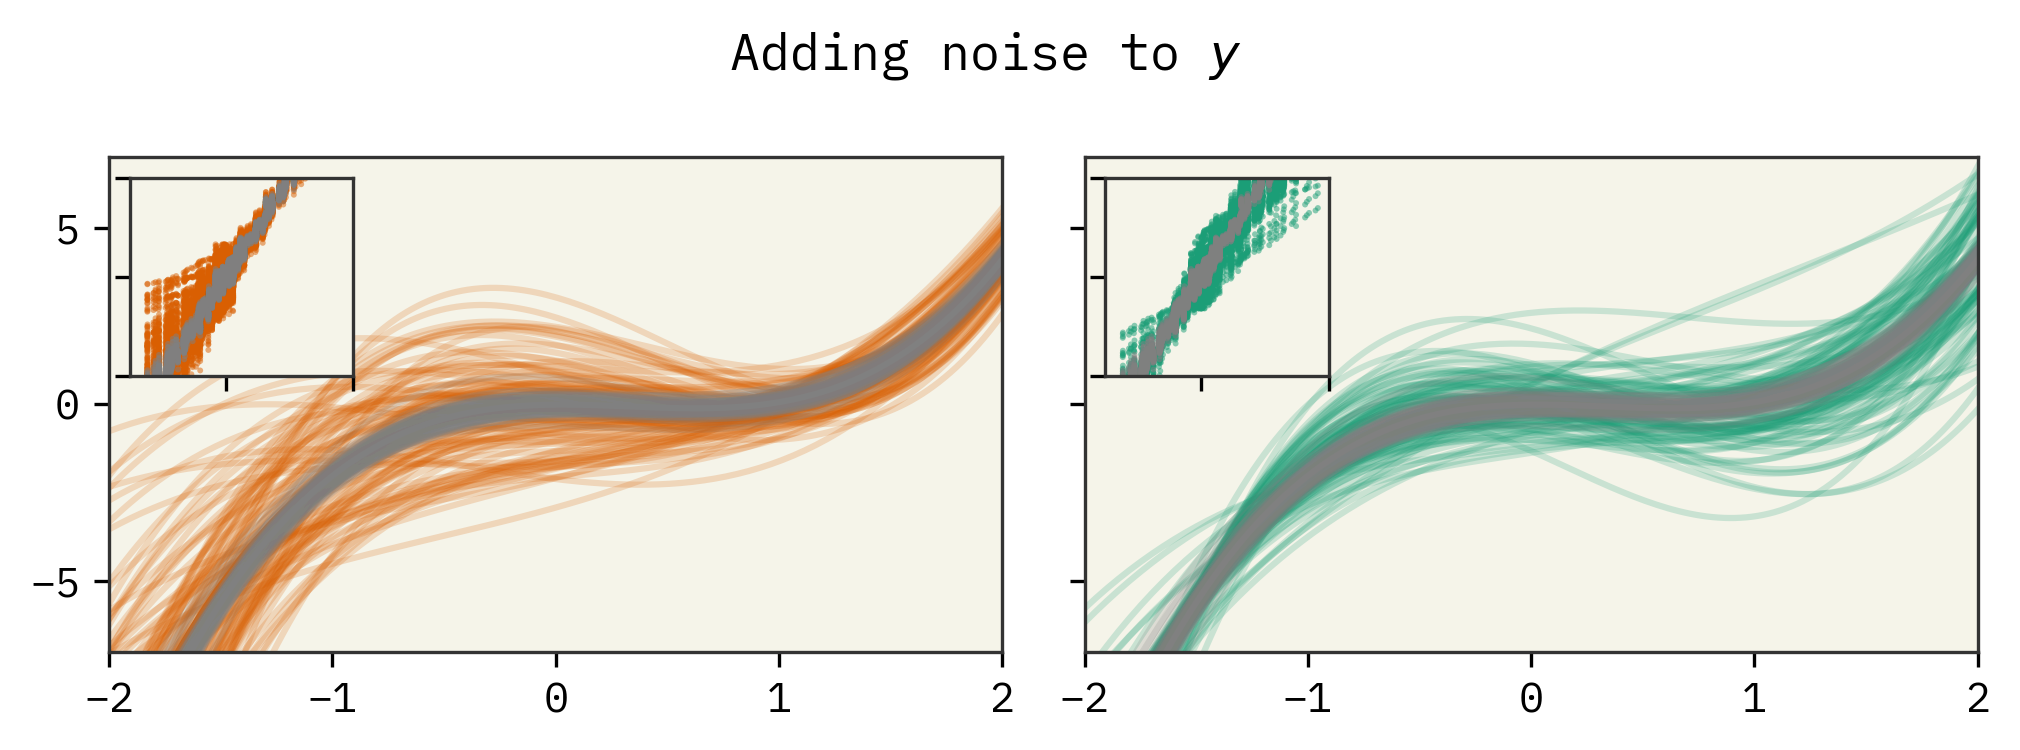

In [14]:
fig, (ax1,ax0) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(7,2.5))
fig.suptitle('Adding noise to $y$')
axins0 = inset_axes(ax0, width="25%", height="40%", loc=2)
axins1 = inset_axes(ax1, width="25%", height="40%", loc=2)

N = 101
M = 200
TRAIN_N = 25
all_x = np.linspace(-2,3, M)
all_y = all_x ** 3 - all_x**2 + 0.5 * np.random.normal(size=(M,))
all_xmat = np.stack((np.ones_like(all_x), all_x, all_x**2, all_x**3), axis=1)
yhats = np.zeros((4, N * M))
index = 0

avg = np.zeros_like(all_x)
for i in range(N):
    x, y = get_split(all_x, all_y, TRAIN_N)
    y +=  5 * np.random.normal(size=x.shape) * np.clip(y, 0, 1) # noising positive y
    xmat = np.stack((np.ones_like(x), x, x**2, x**3), axis=1)
    beta = np.linalg.lstsq(xmat, y, rcond=None)
    yhats[index, i * M:(i+1) * M] = all_xmat @ beta[0]
    ax0.plot(all_x, all_xmat @ beta[0], 'C0', alpha=0.2)
    avg += all_xmat @ beta[0]
ax0.plot(all_x, avg / N, 'C0', label='y>0 noising')
index += 1

avg = np.zeros_like(all_x)
for i in range(N):
    x, y = get_split(all_x, all_y, TRAIN_N)
    y +=  5 * np.random.normal(size=x.shape) * np.clip(y, -1, 0) 
    xmat = np.stack((np.ones_like(x), x, x**2, x**3), axis=1)
    beta = np.linalg.lstsq(xmat, y, rcond=None)
    yhats[index, i * M:(i+1) * M] = all_xmat @ beta[0]
    ax1.plot(all_x, all_xmat @ beta[0], 'C1', alpha=0.2)
    avg += all_xmat @ beta[0]
ax1.plot(all_x, avg / N, 'C1', label='y<0 noising')
index += 1

avg = np.zeros_like(all_x)
for i in range(N):
    x, y = get_split(all_x, all_y, TRAIN_N)
    xmat =  np.stack((np.ones_like(x), x, x**2, x**3), axis=1)
    beta = np.linalg.lstsq(xmat, y, rcond=None)
    yhats[index, i * M:(i+1) * M] = all_xmat @ beta[0]
    ax0.plot(all_x, all_xmat @ beta[0], 'gray', alpha=0.2)
    ax1.plot(all_x, all_xmat @ beta[0], 'gray', alpha=0.2)
    avg += all_xmat @ beta[0]
ax0.plot(all_x, avg / N, 'gray', label='no noising')
ax1.plot(all_x, avg / N, 'gray', label='no noising')


ax0.set(xlim=(-2, 2), ylim=(-7, 7)) #, xlabel='x', ylabel='y')
ax1.set(xlim=(-2, 2), ylim=(-7, 7)) #, xlabel='x', ylabel='y')

all_y = np.tile(all_y, N)
axins0.scatter(all_y, yhats[0], s=2, color='C0', alpha=0.5, edgecolors='none', label='y > 0 noising')
axins0.scatter(all_y, yhats[2], s=2, color='gray', alpha=0.5,  edgecolors='none', label='no noising')
axins0.tick_params(labelleft=False, labelbottom=False)
axins0.set(xlim=(-15,20),ylim=(-10,10))
axins1.scatter(all_y, yhats[1], s=2, color='C1', alpha=0.5,edgecolors='none',  label='y < 0 noising')
axins1.scatter(all_y, yhats[2], s=2, color='gray', alpha=0.5,  edgecolors='none', label='no noising')
axins1.tick_params(labelleft=False, labelbottom=False)
axins1.set(xlim=(-15,20),ylim=(-10,10))

fig.tight_layout()
plt.savefig('polyreg_ynoise.png',dpi=300)



#### X noise

<ipython-input-15-ba530805f16c>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


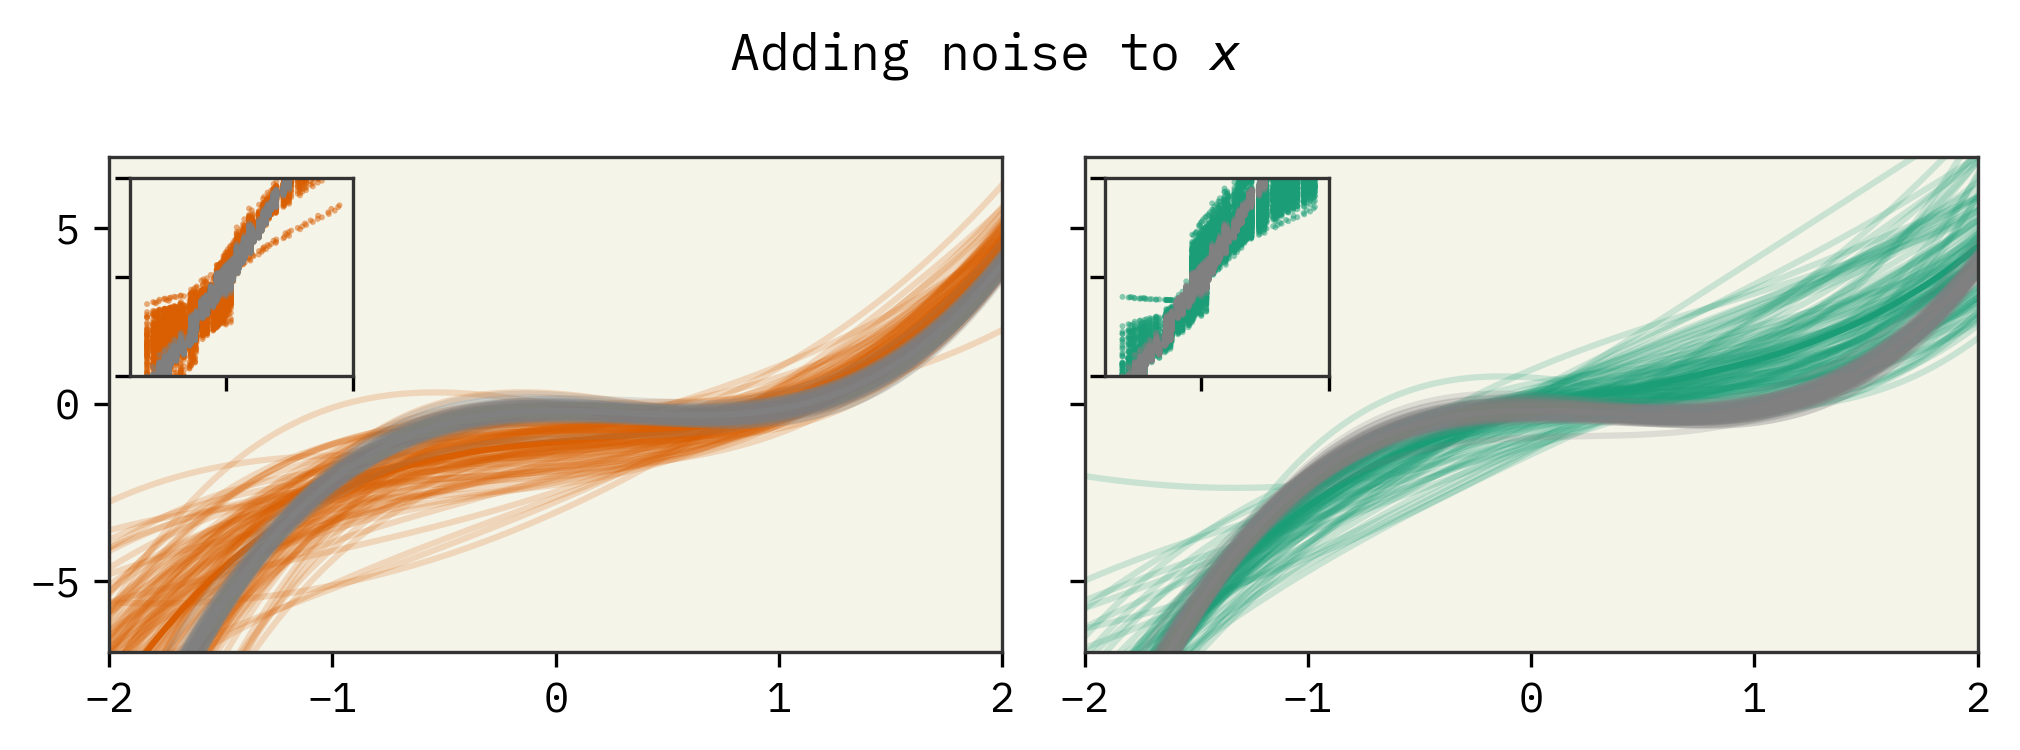

In [15]:
fig, (ax1,ax0) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(7,2.5))
fig.suptitle('Adding noise to $x$')
axins0 = inset_axes(ax0, width="25%", height="40%", loc=2)
axins1 = inset_axes(ax1, width="25%", height="40%", loc=2)

N = 101
M = 200
TRAIN_N = 25
all_x = np.linspace(-2,3, M)
all_y = all_x ** 3 - all_x**2 + 0.5 * np.random.normal(size=(M,))
all_xmat = np.stack((np.ones_like(all_x), all_x, all_x**2, all_x**3), axis=1)
yhats = np.zeros((4, N * M))
index = 0

avg = np.zeros_like(all_x)
for i in range(N):
    x, y = get_split(all_x, all_y, TRAIN_N)
    x +=  0.5 * np.random.normal(size=x.shape) * np.clip(y, 0, 1) # noising positive y
    xmat = np.stack((np.ones_like(x), x, x**2, x**3), axis=1)
    beta = np.linalg.lstsq(xmat, y, rcond=None)
    yhats[index, i * M:(i+1) * M] = all_xmat @ beta[0]
    ax0.plot(all_x, all_xmat @ beta[0], 'C0', alpha=0.2)
    avg += all_xmat @ beta[0]
ax0.plot(all_x, avg / N, 'C0', label='x>0 noising')
index += 1

avg = np.zeros_like(all_x)
for i in range(N):
    x, y = get_split(all_x, all_y, TRAIN_N)
    x +=  0.5 * np.random.normal(size=x.shape) * np.clip(y, -1, 0) 
    xmat = np.stack((np.ones_like(x), x, x**2, x**3), axis=1)
    beta = np.linalg.lstsq(xmat, y, rcond=None)
    yhats[index, i * M:(i+1) * M] = all_xmat @ beta[0]
    ax1.plot(all_x, all_xmat @ beta[0], 'C1', alpha=0.2)
    avg += all_xmat @ beta[0]
ax1.plot(all_x, avg / N, 'C1', label='x<0 noising')
index += 1

avg = np.zeros_like(all_x)
for i in range(N):
    x, y = get_split(all_x, all_y, TRAIN_N)
    xmat =  np.stack((np.ones_like(x), x, x**2, x**3), axis=1)
    beta = np.linalg.lstsq(xmat, y, rcond=None)
    yhats[index, i * M:(i+1) * M] = all_xmat @ beta[0]
    ax0.plot(all_x, all_xmat @ beta[0], 'gray', alpha=0.2)
    ax1.plot(all_x, all_xmat @ beta[0], 'gray', alpha=0.2)
    avg += all_xmat @ beta[0]
ax0.plot(all_x, avg / N, 'gray', label='no noising')
ax1.plot(all_x, avg / N, 'gray', label='no noising')


ax0.set(xlim=(-2, 2), ylim=(-7, 7)) #, xlabel='x', ylabel='y')
ax1.set(xlim=(-2, 2), ylim=(-7, 7)) #, xlabel='x', ylabel='y')

all_y = np.tile(all_y, N)
axins0.scatter(all_y, yhats[0], s=2, color='C0', alpha=0.5, edgecolors='none', label='x > 0 noising')
axins0.scatter(all_y, yhats[2], s=2, color='gray', alpha=0.5,  edgecolors='none', label='no noising')
axins0.tick_params(labelleft=False, labelbottom=False)
axins0.set(xlim=(-15,20),ylim=(-10,10))
axins1.scatter(all_y, yhats[1], s=2, color='C1', alpha=0.5,edgecolors='none',  label='x < 0 noising')
axins1.scatter(all_y, yhats[2], s=2, color='gray', alpha=0.5,  edgecolors='none', label='no noising')
axins1.tick_params(labelleft=False, labelbottom=False)
axins1.set(xlim=(-15,20),ylim=(-10,10))

fig.tight_layout()
plt.savefig('polyreg_xnoise.png',dpi=300)



#### XY noise

<ipython-input-16-ce632ed7376e>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


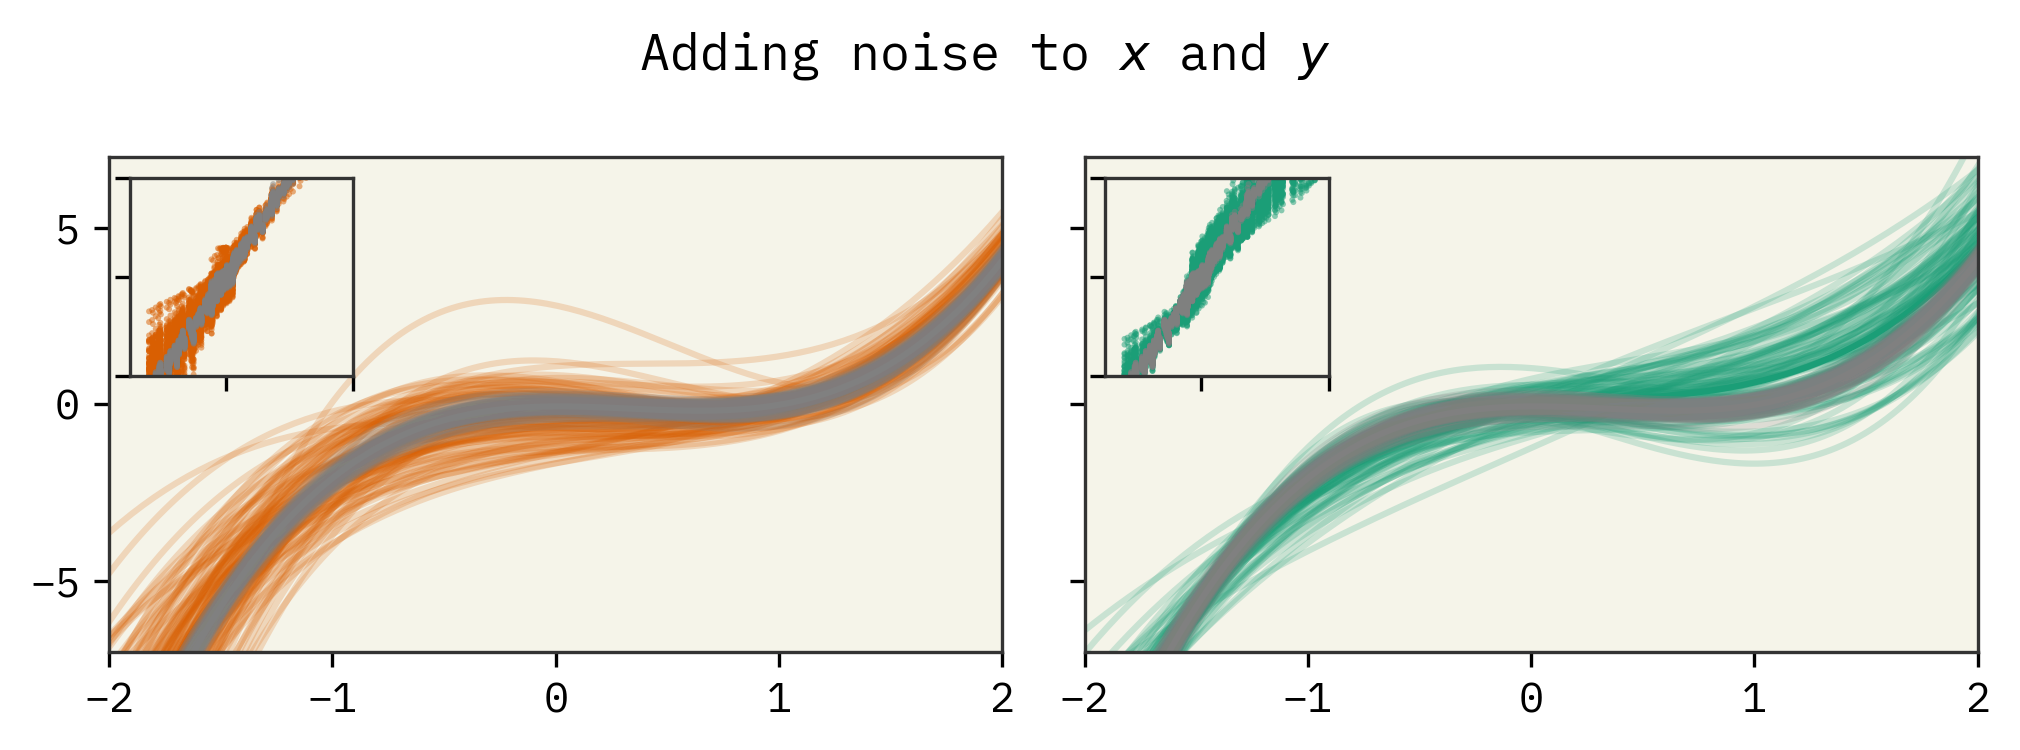

In [16]:
fig, (ax1,ax0) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(7,2.5))
fig.suptitle('Adding noise to $x$ and $y$')
axins0 = inset_axes(ax0, width="25%", height="40%", loc=2)
axins1 = inset_axes(ax1, width="25%", height="40%", loc=2)

N = 101
M = 200
TRAIN_N = 25
all_x = np.linspace(-2,3, M)
all_y = all_x ** 3 - all_x**2 + 0.5 * np.random.normal(size=(M,))
all_xmat = np.stack((np.ones_like(all_x), all_x, all_x**2, all_x**3), axis=1)
yhats = np.zeros((4, N * M))
index = 0

avg = np.zeros_like(all_x)
for i in range(N):
    x, y = get_split(all_x, all_y, TRAIN_N)
    x +=  0.25 * np.random.normal(size=x.shape) * np.clip(y, 0, 1) # noising positive y
    y +=  2.5 * np.random.normal(size=x.shape) * np.clip(y, 0, 1) 
    xmat = np.stack((np.ones_like(x), x, x**2, x**3), axis=1)
    beta = np.linalg.lstsq(xmat, y, rcond=None)
    yhats[index, i * M:(i+1) * M] = all_xmat @ beta[0]
    ax0.plot(all_x, all_xmat @ beta[0], 'C0', alpha=0.2)
    avg += all_xmat @ beta[0]
ax0.plot(all_x, avg / N, 'C0', label='x>0 noising')
index += 1

avg = np.zeros_like(all_x)
for i in range(N):
    x, y = get_split(all_x, all_y, TRAIN_N)
    x +=  0.25 * np.random.normal(size=x.shape) * np.clip(y, -1, 0) 
    y +=  2.5 * np.random.normal(size=x.shape) * np.clip(y, -1, 0) 
    xmat = np.stack((np.ones_like(x), x, x**2, x**3), axis=1)
    beta = np.linalg.lstsq(xmat, y, rcond=None)
    yhats[index, i * M:(i+1) * M] = all_xmat @ beta[0]
    ax1.plot(all_x, all_xmat @ beta[0], 'C1', alpha=0.2)
    avg += all_xmat @ beta[0]
ax1.plot(all_x, avg / N, 'C1', label='x<0 noising')
index += 1

avg = np.zeros_like(all_x)
for i in range(N):
    x, y = get_split(all_x, all_y, TRAIN_N)
    xmat =  np.stack((np.ones_like(x), x, x**2, x**3), axis=1)
    beta = np.linalg.lstsq(xmat, y, rcond=None)
    yhats[index, i * M:(i+1) * M] = all_xmat @ beta[0]
    ax0.plot(all_x, all_xmat @ beta[0], 'gray', alpha=0.2)
    ax1.plot(all_x, all_xmat @ beta[0], 'gray', alpha=0.2)
    avg += all_xmat @ beta[0]
ax0.plot(all_x, avg / N, 'gray', label='no noising')
ax1.plot(all_x, avg / N, 'gray', label='no noising')


ax0.set(xlim=(-2, 2), ylim=(-7, 7)) #, xlabel='x', ylabel='y')
ax1.set(xlim=(-2, 2), ylim=(-7, 7)) #, xlabel='x', ylabel='y')

all_y = np.tile(all_y, N)
axins0.scatter(all_y, yhats[0], s=2, color='C0', alpha=0.5, edgecolors='none', label='x > 0 noising')
axins0.scatter(all_y, yhats[2], s=2, color='gray', alpha=0.5,  edgecolors='none', label='no noising')
axins0.tick_params(labelleft=False, labelbottom=False)
axins0.set(xlim=(-15,20),ylim=(-10,10))
axins1.scatter(all_y, yhats[1], s=2, color='C1', alpha=0.5,edgecolors='none',  label='x < 0 noising')
axins1.scatter(all_y, yhats[2], s=2, color='gray', alpha=0.5,  edgecolors='none', label='no noising')
axins1.tick_params(labelleft=False, labelbottom=False)
axins1.set(xlim=(-15,20),ylim=(-10,10))

fig.tight_layout()
plt.savefig('polyreg_xynoise.png',dpi=300)

